# Customer Churn Prediction (End-to-End ML + Streamlit App)

**Goal:** Predict which telecom customers are likely to churn so the business can act before losing them.

**Business impact:** Target at-risk customers with retention offers -> reduces revenue loss.

**Tech stack:** pandas, scikit-learn, SMOTE (class imbalance), XGBoost, joblib, Streamlit (interactive app).

**Key result:** Best model = [XGBoost / Random Forest, etc.] with F1 score on churn class = 0.87 (after SMOTE).


## 1. Data Load & Initial Look

We load the customer churn dataset (telecom-style), inspect shape, sample rows, and class balance.
This helps us understand:
- How many rows
- What the target column (`Churn`) looks like
- How imbalanced the problem is


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, f1_score)
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import xgboost as xgb
from scipy.stats import randint, uniform

import joblib
import warnings
warnings.filterwarnings("ignore")
RANDOM_STATE = 42

In [ ]:
df = pd.read_csv("data/customer_churn_data.csv")
df.head(6)

,CustomerID,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
0,1,49,Male,4,88.35,Month-to-Month,Fiber Optic,353.40,Yes,Yes
1,2,43,Male,0,36.67,Month-to-Month,Fiber Optic,0.00,Yes,Yes
2,3,51,Female,2,63.79,Month-to-Month,Fiber Optic,127.58,No,Yes
3,4,60,Female,8,102.34,One-Year,DSL,818.72,Yes,Yes
4,5,42,Male,32,69.01,Month-to-Month,NaN,2208.32,No,Yes
5,6,42,Female,16,119.75,Two-Year,DSL,1916.00,Yes,Yes


In [3]:
df.describe()

,CustomerID,Age,Tenure,MonthlyCharges,TotalCharges
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,44.674000,18.97300,74.391290,1404.364060
std,288.819436,9.797741,18.89257,25.712083,1571.755048
min,1.000000,12.000000,0.00000,30.000000,0.000000
25%,250.750000,38.000000,5.00000,52.357500,345.217500
50%,500.500000,45.000000,13.00000,74.060000,872.870000
75%,750.250000,51.000000,26.00000,96.102500,1900.175000
max,1000.000000,83.000000,122.00000,119.960000,12416.250000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerID       1000 non-null   int64  
 1   Age              1000 non-null   int64  
 2   Gender           1000 non-null   object 
 3   Tenure           1000 non-null   int64  
 4   MonthlyCharges   1000 non-null   float64
 5   ContractType     1000 non-null   object 
 6   InternetService  703 non-null    object 
 7   TotalCharges     1000 non-null   float64
 8   TechSupport      1000 non-null   object 
 9   Churn            1000 non-null   object 
dtypes: float64(2), int64(3), object(5)
memory usage: 78.3+ KB


In [5]:
df.shape

(1000, 10)

In [6]:
df.isna().sum()

CustomerID           0
Age                  0
Gender               0
Tenure               0
MonthlyCharges       0
ContractType         0
InternetService    297
TotalCharges         0
TechSupport          0
Churn                0
dtype: int64

In [7]:
df.nunique()

CustomerID         1000
Age                  57
Gender                2
Tenure               87
MonthlyCharges      935
ContractType          3
InternetService       2
TotalCharges        943
TechSupport           2
Churn                 2
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

## 2. Data Cleaning & Preprocessing

Steps:
1. Drop identifier columns that don't help prediction.
2. Handle missing values.



In [9]:
df = df.drop(columns='CustomerID',axis=1)

In [10]:
df['InternetService'].value_counts()

InternetService
Fiber Optic    395
DSL            308
Name: count, dtype: int64

Filled Internet Service with the most common service, "Fiber Optic".

In [11]:
df['InternetService'] = df['InternetService'].fillna('Fiber Optic')

In [12]:
df['InternetService'].value_counts()

InternetService
Fiber Optic    692
DSL            308
Name: count, dtype: int64

In [13]:
df.isna().sum()

Age                0
Gender             0
Tenure             0
MonthlyCharges     0
ContractType       0
InternetService    0
TotalCharges       0
TechSupport        0
Churn              0
dtype: int64

In [14]:
df['Churn'].value_counts()

Churn
Yes    883
No     117
Name: count, dtype: int64

In [15]:
df['Churn'].value_counts(normalize=True) * 100  # % churners vs non-churners

Churn
Yes    88.3
No     11.7
Name: proportion, dtype: float64

## 3. Exploratory Data Analysis (EDA)

We'll look at:
- Churn rate distribution
- Tenure / MonthlyCharges patterns
- Which groups are most at risk (e.g. contract type)
- Correlations between numeric features


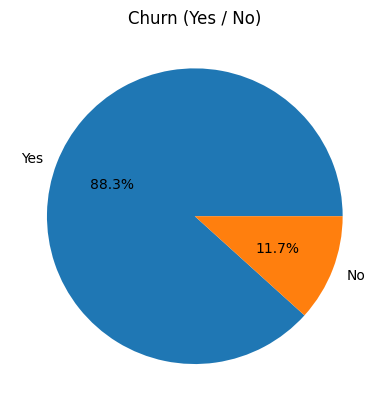

In [16]:
df['Churn'].value_counts().plot(kind='pie', autopct='%1.1f%%', ylabel='')
plt.title('Churn (Yes / No)')
plt.show()

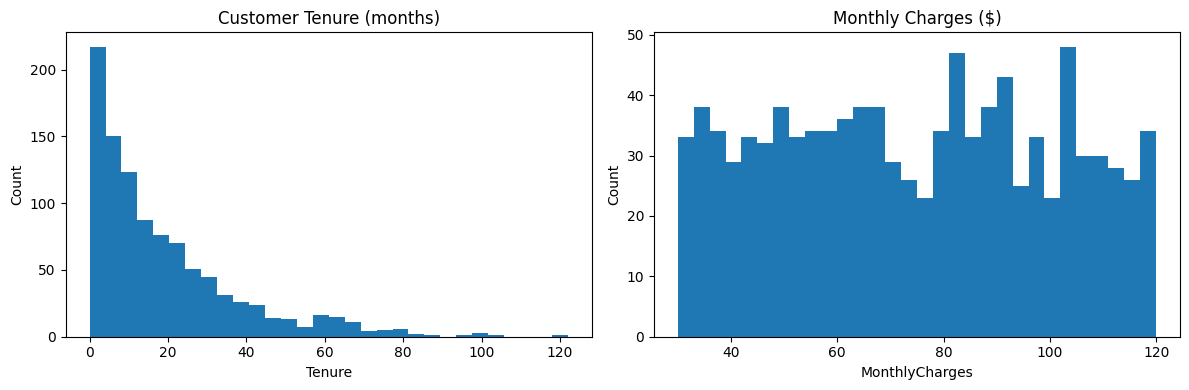

In [17]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(df['Tenure'], bins=30)
ax[0].set_title("Customer Tenure (months)")
ax[0].set_xlabel("Tenure"); ax[0].set_ylabel("Count")

ax[1].hist(df['MonthlyCharges'], bins=30)
ax[1].set_title("Monthly Charges ($)")
ax[1].set_xlabel("MonthlyCharges"); ax[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

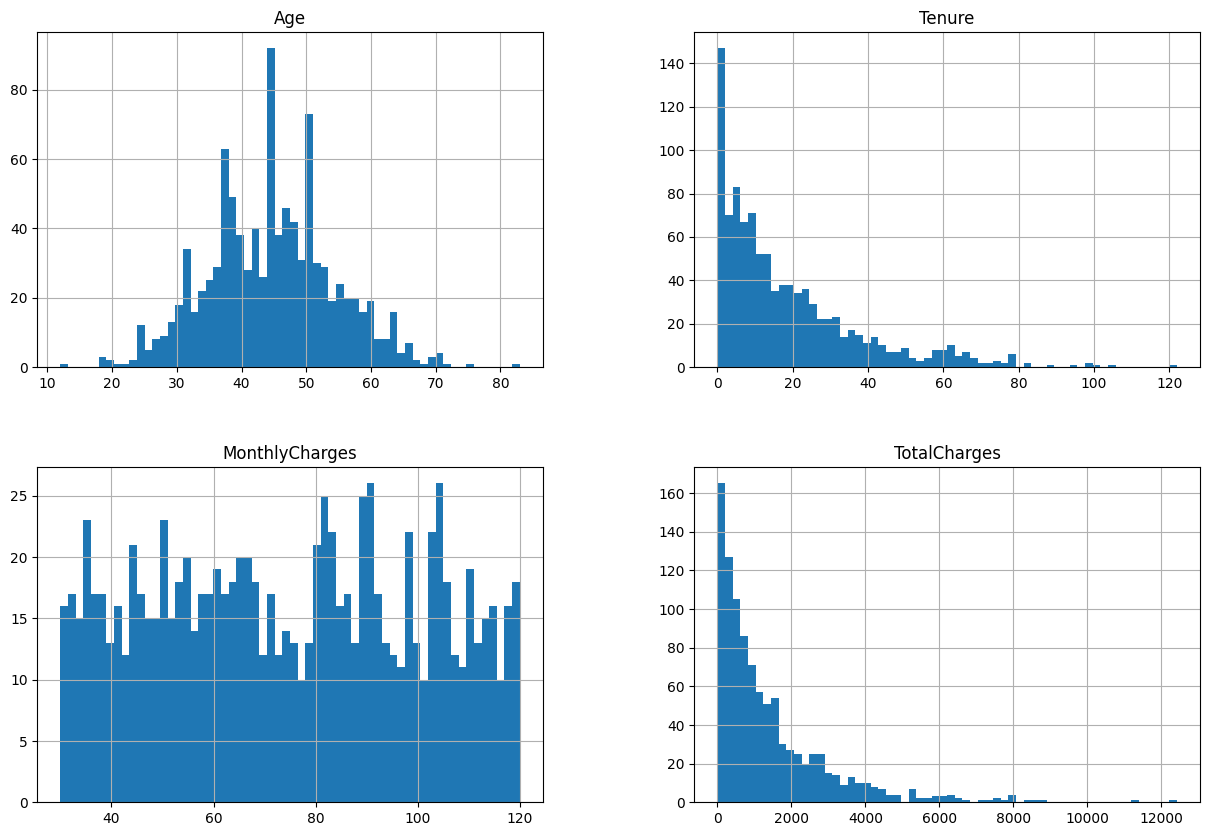

In [18]:
df.hist(bins=60, figsize = (15,10)) 
plt.show()

In [19]:
df[df['Tenure']>81]

,Age,Gender,Tenure,MonthlyCharges,ContractType,InternetService,TotalCharges,TechSupport,Churn
18,35,Male,98,49.59,Two-Year,Fiber Optic,4859.82,Yes,No
112,45,Female,88,51.73,Month-to-Month,Fiber Optic,4552.24,Yes,Yes
136,37,Female,82,98.11,Month-to-Month,Fiber Optic,8045.02,No,Yes
164,54,Male,101,54.78,Month-to-Month,Fiber Optic,5532.78,No,Yes
233,38,Female,122,69.58,Month-to-Month,DSL,8488.76,No,Yes
440,48,Male,94,89.57,One-Year,Fiber Optic,8419.58,No,Yes
493,36,Female,105,118.25,Month-to-Month,DSL,12416.25,Yes,Yes
540,53,Male,99,113.93,Month-to-Month,Fiber Optic,11279.07,No,Yes
631,60,Female,83,89.36,Month-to-Month,Fiber Optic,7416.88,Yes,Yes


<Axes: xlabel='Tenure'>

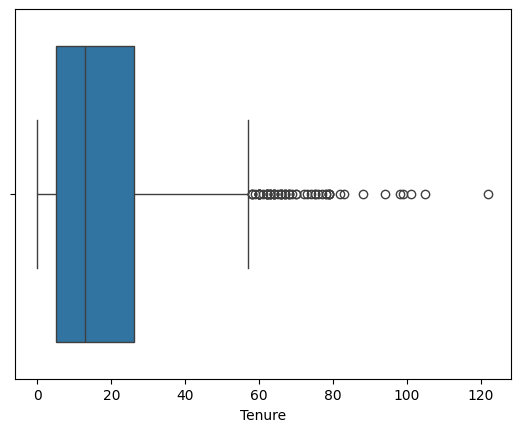

In [20]:
sns.boxplot(x=df['Tenure']) #Maybe drop rows > 60

In [21]:
df.corr(numeric_only=True).style.background_gradient()

,Age,Tenure,MonthlyCharges,TotalCharges
Age,1.000000,0.000472,0.006362,-0.001896
Tenure,0.000472,1.000000,-0.014552,0.894868
MonthlyCharges,0.006362,-0.014552,1.000000,0.304893
TotalCharges,-0.001896,0.894868,0.304893,1.000000


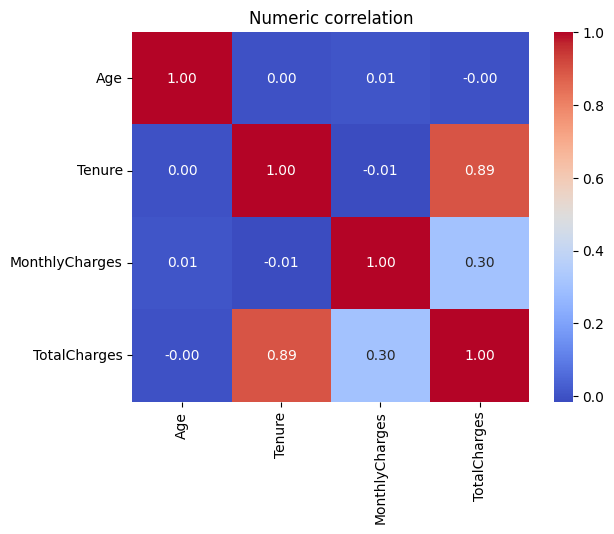

In [22]:
sns.heatmap(df.corr(numeric_only=True), annot = True, cmap='coolwarm', fmt='.2f')
plt.title('Numeric correlation')
plt.show()

In [23]:
df['Churn'].value_counts() ##SMOTE / ADASYN

Churn
Yes    883
No     117
Name: count, dtype: int64

In [24]:
df.groupby('Churn')['MonthlyCharges'].mean()

Churn
No     62.54641
Yes    75.96077
Name: MonthlyCharges, dtype: float64

In [25]:
df.groupby(['Churn','Gender'])['MonthlyCharges'].mean()

Churn  Gender
No     Female    65.091912
       Male      59.013878
Yes    Female    74.975064
       Male      77.082518
Name: MonthlyCharges, dtype: float64

In [26]:
df.groupby('Churn')['Tenure'].mean()

Churn
No     30.264957
Yes    17.476784
Name: Tenure, dtype: float64

In [27]:
df.groupby('Churn')['Age'].mean()

Churn
No     43.487179
Yes    44.831257
Name: Age, dtype: float64

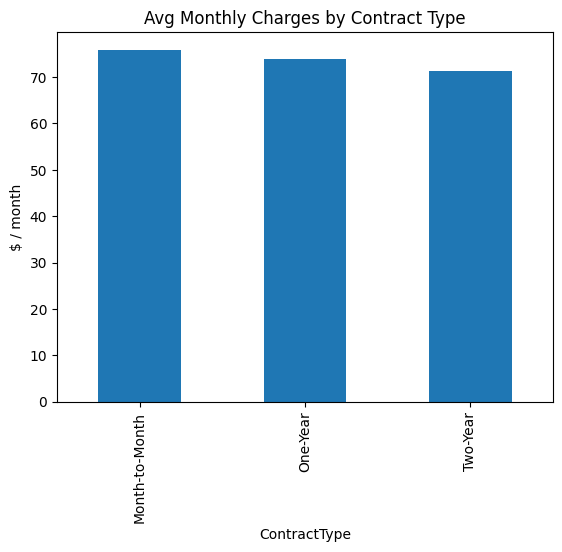

In [28]:
df.groupby('Churn')['MonthlyCharges'].mean()
df.groupby('Churn')['Tenure'].mean()
df.groupby('ContractType')['MonthlyCharges'].mean().plot(kind='bar')
plt.title('Avg Monthly Charges by Contract Type')
plt.ylabel('$ / month')
plt.show()

Customers who churn tend to have higher monthly charges and lower tenure. Month-to-month contracts are higher risk than long-term contracts.
This suggests retention offers should focus on high-cost, low-tenure customers on short contracts.

## 4. Feature Engineering
1. Encode categorical features and scale numeric features using OneHotEncoder, LabelEncoder for Target variable, and StandardScaler.
2. Separate features (X) and target (y).
3. Split train/test with stratification to preserve churn ratio.
4. Use SMOTE to address class imbalance.


In [29]:
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
gender_encoded = ohe.fit_transform(df[['Gender']])
gender_encoded_df = pd.DataFrame(gender_encoded, columns=ohe.get_feature_names_out(['Gender']), index=df.index)
X = pd.concat([df[['Age','MonthlyCharges','Tenure']], gender_encoded_df], axis=1)

scaler = StandardScaler()
X[['Age','MonthlyCharges','Tenure']] = scaler.fit_transform(X[['Age','MonthlyCharges','Tenure']])
y = df['Churn']

In [30]:
X.head()

,Age,MonthlyCharges,Tenure,Gender_Female,Gender_Male
0,0.441751,0.543157,-0.792930,0.0,1.0
1,-0.170941,-1.467799,-1.004760,0.0,1.0
2,0.645982,-0.412514,-0.898845,1.0,0.0
3,1.565021,1.087531,-0.581101,1.0,0.0
4,-0.273057,-0.209395,0.689875,0.0,1.0


In [31]:
le = LabelEncoder()
y= le.fit_transform(df['Churn']) #No = 0 , Yes = 1

In [32]:
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify=y)

We use SMOTE to oversample the minority (churn = Yes) class. This helps the model learn churn patterns instead of being biased toward the majority class.

In [33]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [34]:
print("Before SMOTE:", pd.Series(y_train).value_counts())
print("After SMOTE:", pd.Series(y_train_smote).value_counts())

Before SMOTE: 1    706
0     94
Name: count, dtype: int64
After SMOTE: 1    706
0    706
Name: count, dtype: int64


In [35]:
X_train.shape

(800, 5)

In [36]:
X_test.shape

(200, 5)

In [37]:
X_test.value_counts()

Age        MonthlyCharges  Tenure     Gender_Female  Gender_Male
-3.336519  -1.439393       -0.951802  1.0            0.0            1
-2.519596  -0.055305       -0.210400  1.0            0.0            1
-2.315365  -1.090745        2.066766  0.0            1.0            1
-2.111134  -1.204756       -0.157442  0.0            1.0            1
            0.293344        0.689875  0.0            1.0            1
                                                                   ..
 1.973483  -1.365850        0.001430  0.0            1.0            1
 2.075598  -1.114092       -0.634058  1.0            0.0            1
 2.484060  -1.586090       -0.369272  1.0            0.0            1
            1.184810       -0.210400  0.0            1.0            1
 2.790406   1.084029        1.113534  1.0            0.0            1
Name: count, Length: 200, dtype: int64

## 5. Modeling

### 5.1 Baseline: Logistic Regression

We start with Logistic Regression, first on the raw imbalanced data, then after applying SMOTE to rebalance the churn class.
We compare accuracy and F1 on the test set.

Testing without SMOTE to show imbalance f1 score difference.

In [38]:
LogR_nosmote = LogisticRegression(max_iter=1000)

LogR_nosmote.fit(X_train, y_train)
y_pred = LogR_nosmote.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)


print('accuracy score:' , accuracy)
print('f1 score:' , f1)

accuracy score: 0.875
f1 score: 0.9333333333333333


With SMOTE, you can see how far the f1 score dropped.

In [39]:
logR = LogisticRegression(max_iter = 1000)

logR.fit(X_train_smote,y_train_smote)
y_pred = logR.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test,y_pred)

print('accuracy score:' , accuracy)
print('f1 score:' , f1)

accuracy score: 0.655
f1 score: 0.7722772277227723


In [40]:
# Without SMOTE
y_pred_nosmote = LogR_nosmote.predict(X_test)
print("-----Without SMOTE-----")
print(classification_report(y_test, y_pred_nosmote, target_names=['No', 'Yes']))

# With SMOTE
y_pred_smote = logR.predict(X_test)
print("-----With SMOTE-----")
print(classification_report(y_test, y_pred_smote, target_names=['No', 'Yes']))

-----Without SMOTE-----
              precision    recall  f1-score   support

          No       0.00      0.00      0.00        23
         Yes       0.88      0.99      0.93       177

    accuracy                           0.88       200
   macro avg       0.44      0.49      0.47       200
weighted avg       0.78      0.88      0.83       200

-----With SMOTE-----
              precision    recall  f1-score   support

          No       0.19      0.61      0.29        23
         Yes       0.93      0.66      0.77       177

    accuracy                           0.66       200
   macro avg       0.56      0.63      0.53       200
weighted avg       0.84      0.66      0.72       200



**Interpretation:**  
The confusion matrix shows how many churners we correctly caught (True Positives).  
A high False Negative count = customers who churned but we failed to flag.  
In churn prevention, missing churners (FN) is usually more expensive than accidentally flagging a loyal customer (FP).

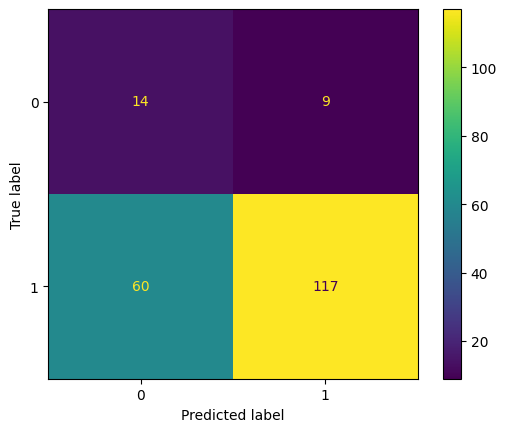

In [41]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()

Interpretability: 

True Negatives (TN) = 19 → correctly predicted No

False Positives (FP) = 4 → incorrectly predicted Yes

False Negatives (FN) = 67 → incorrectly predicted No

True Positives (TP) = 110 → correctly predicted Yes

### 5.2 Model Comparison

We train multiple classifiers (Random Forest, Gradient Boosting, XGBoost, etc.) on the balanced data and score them on the same held-out test set. We also run hyperparameter search (GridSearchCV / RandomizedSearchCV) for the top performers.


In [42]:
models ={
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Adaboost': AdaBoostClassifier(random_state=42), 
    'SVM': SVC(probability=True, random_state=42),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss',random_state=42)
}

for name, model in models.items():
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    print(f"----{name}-----")
    print('Accuracy: ', accuracy_score(y_test,y_pred))
    print('F1 score: ' , f1_score(y_test,y_pred))
    print()

----Decision Tree-----
Accuracy:  0.775
F1 score:  0.8648648648648649

----Random Forest-----
Accuracy:  0.825
F1 score:  0.8948948948948949

----Gradient Boosting-----
Accuracy:  0.75
F1 score:  0.8376623376623377

----Adaboost-----
Accuracy:  0.68
F1 score:  0.7793103448275862

----SVM-----
Accuracy:  0.72
F1 score:  0.8169934640522876

----KNN-----
Accuracy:  0.76
F1 score:  0.8509316770186336

----XGBoost-----
Accuracy:  0.815
F1 score:  0.8882175226586103



In [43]:
rfc = RandomForestClassifier(random_state=42)

rfc_params ={
    'n_estimators':[100,200],
    'max_depth':[None, 5,10],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2]}

grid_rfc = GridSearchCV(
    estimator=rfc, 
    param_grid=rfc_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1)

grid_rfc.fit(X_train_smote, y_train_smote)
print("Best RFC params:" , grid_rfc.best_params_)
print('Best RFC F1: ', grid_rfc.best_score_)
y_pred = grid_rfc.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RFC params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best RFC F1:  0.8880413636497776
Test Accuracy: 0.825
Test F1: 0.8948948948948949


In [44]:
gb = GradientBoostingClassifier(random_state=42)

gb_params ={
    'n_estimators':[100,200],
    'learning_rate':[0.05,0.1],
    'max_depth':[3,5]}

grid_gb = GridSearchCV(
    estimator = gb,
    param_grid=gb_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1)

grid_gb.fit(X_train_smote,y_train_smote)
print("Best GB params:", grid_gb.best_params_)
print("Best GB F1:", grid_gb.best_score_)
y_pred = grid_gb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best GB params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
Best GB F1: 0.8815115643967226
Test Accuracy: 0.815
Test F1: 0.8888888888888888


In [45]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42)

xgb_params={
    'n_estimators':[100,200],
    'learning_rate':[0.05,0.1],
    'max_depth':[3,5],
    'subsample':[0.7,1],
    'colsample_bytree':[0.7,1]}
grid_xgb = GridSearchCV(
    estimator = xgb_model,
    param_grid=xgb_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1)
grid_xgb.fit(X_train_smote,y_train_smote)
print("Best XBG Params:", grid_xgb.best_params_)
print("Best XGB F1:" ,grid_xgb.best_score_)
y_pred = grid_xgb.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best XBG Params: {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
Best XGB F1: 0.8865992266961775
Test Accuracy: 0.795
Test F1: 0.8761329305135952


In [46]:
# Random Forest Randomized Search
rfc = RandomForestClassifier(random_state=42)

rfc_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 15),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

rand_rfc = RandomizedSearchCV(
    estimator=rfc,
    param_distributions=rfc_dist,
    n_iter=20,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=1)

rand_rfc.fit(X_train_smote, y_train_smote)
print("Best RF params (Random):", rand_rfc.best_params_)
print("Best RF F1 (Random):", rand_rfc.best_score_)
y_pred = rand_rfc.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF params (Random): {'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 253}
Best RF F1 (Random): 0.8797723506624532
Test Accuracy: 0.78
Test F1: 0.8633540372670807


Visualizing ROC Curve's for comparisson to best model.

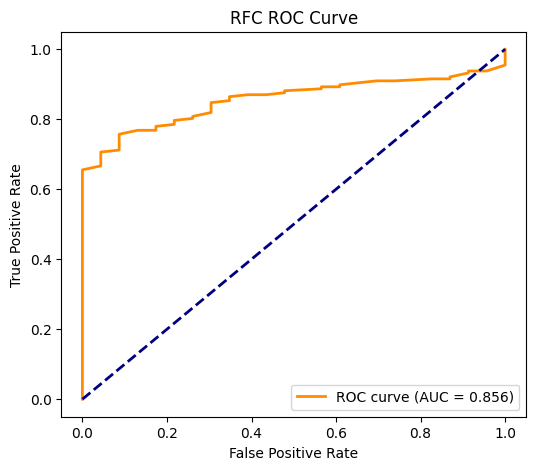

In [47]:
best_rfc = grid_rfc.best_estimator_

y_prob = best_rfc.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RFC ROC Curve')
plt.legend(loc='lower right')
plt.show()

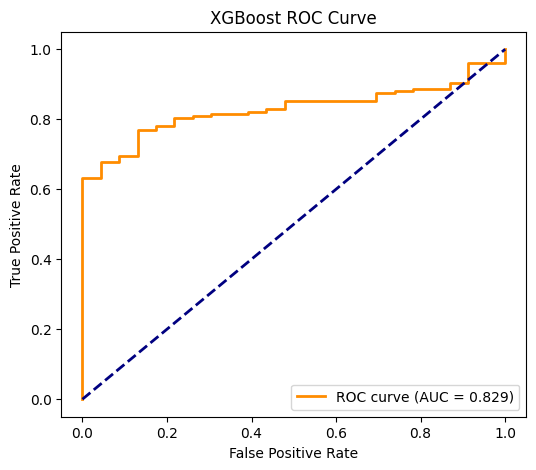

In [48]:
best_xgb = grid_xgb.best_estimator_

y_prob = best_xgb.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc='lower right')
plt.show()

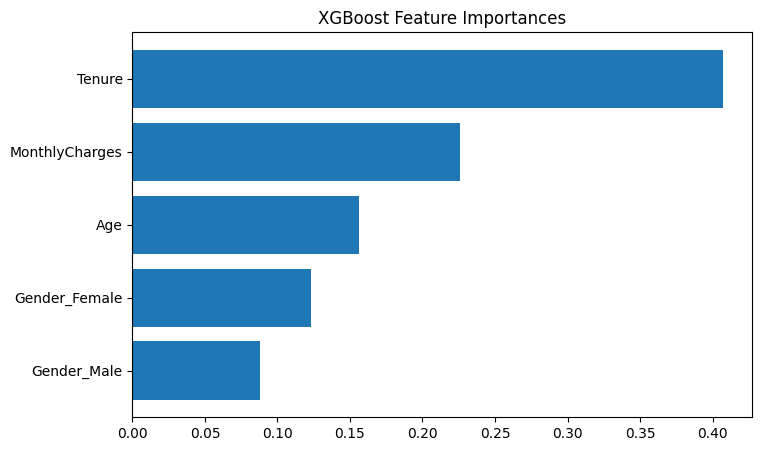

In [49]:
importances = best_xgb.feature_importances_
features = X_train.columns

feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8,5))
plt.barh(feat_df['Feature'], feat_df['Importance'])
plt.gca().invert_yaxis()
plt.title('XGBoost Feature Importances')
plt.show()

Top drivers of churn (from XGBoost feature importance):
- Short tenure
- High monthly charges
- Age (Older -> Higher tendency to churn)
- Male Gender
- Female Gender

These are actionable: you can target high-risk contract types with retention offers.

## 6. Export Model & Preprocessing for App

Exported:
- The trained best model
- The preprocessing pipeline (encoder + scaler),
so that our Streamlit app can load them and score new customers in real time and can be used by non-technical people most importantly.


In [50]:
joblib.dump(best_xgb, 'xgb_best_model.pkl')

['xgb_best_model.pkl']

In [51]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [52]:
joblib.dump(ohe, 'ohe.pkl')

['ohe.pkl']

## 7. Next Steps

- Add cost-sensitive evaluation (penalize missing real churners).
- Log predictions + feedback loop for model monitoring.
- Deploy the Streamlit app via Docker so it can run anywhere.